In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import ellipj, ellipk, ellipkinc, ellipkm1
import axion_motion
import clock_work_axion
import model
import transport_equation
import reheating
import plot_tools
from common import constants, cosmology

In [2]:
def sc(x, y):
    sn, cn, _dn, _ph = ellipj(x, y)
    return sn / cn

In [32]:
def calc_f_eff(f, eps):
    return 2 / np.pi * f * ellipkm1(eps**2)

def calc_f(f_eff, eps):
    return np.pi / 2 * f_eff / ellipkm1(eps**2)

In [34]:
def calc_eps(mR):
    return np.exp(- np.pi * mR)

def calc_m_phi(mR, M):
    return calc_eps(mR) * M

def calc_mass(_T, eps, M):
    return eps * M

def calc_mass_scale(m_phi, eps):
    return m_phi / eps

def calc_u(phi_over_f, eps):
    return eps * sc(phi_over_f / 2, 1 - eps**2)

def calc_V_eff_over_f_sq(phi_over_f, eps, M):
    return M**2 * 2 / (1 + 1 / calc_u(phi_over_f, eps)**2)

def theta_to_phi_over_f(theta, eps):
    return 2 / eps * ellipkinc(theta / 2, - 1 / eps**2)

In [5]:
def calc_du_dphi_times_f(phi_over_f, eps):
    _sn, cn, dn, _ph = ellipj(phi_over_f / 2, 1 - eps**2)
    return eps / 2 * dn / cn**2

def calc_dV_eff_dphi_over_f(phi_over_f, eps, M):
    u = calc_u(phi_over_f, eps)
    return 4 * M**2 * calc_du_dphi_times_f(phi_over_f, eps) / (u**3 * (1 + 1 / u**2)**2)

In [6]:
def rhs(t, y, eps, M, H_fn):
    phi_over_f, phi_dot_over_f = y
    H = H_fn(t)
    phi_dot_dot_over_f = - 3 * H * phi_dot_over_f - calc_dV_eff_dphi_over_f(phi_over_f, eps, M)
    return phi_dot_over_f, phi_dot_dot_over_f

In [7]:
def rhs_log_t(log_t, y, _T_fn, H_fn, p):
    eps, M = p
    t = np.exp(log_t)
    phi_dot_over_f, phi_dot_dot_over_f = rhs(t, y, eps, M, H_fn)
    return phi_dot_over_f * t, phi_dot_dot_over_f * t

In [8]:
def make_rad_dom_H_fn(t_init, T_init):
    T_fn = lambda t: T_init * (t / t_init)**(-0.5)
    H_fn = lambda t: 1 / (2*t)
    return T_fn, H_fn

In [9]:
def calc_theta_dot(phi_over_f, phi_dot_over_f, eps, M):
    MM = 2*M**2
    A = calc_V_eff_over_f_sq(phi_over_f, eps, M) / MM
    return (
        1 / MM * np.abs(calc_dV_eff_dphi_over_f(phi_over_f, eps, M)) * phi_dot_over_f
        / ((1 - A)*A)**0.5
    )
def get_axion_source_clockwork(field_fn, p):
    eps, M = p
    def source_fn(log_t):
        phi_over_f, phi_dot_over_f = field_fn(log_t)
        return calc_theta_dot(phi_over_f, phi_dot_over_f, eps, M)
    return source_fn

In [10]:
def calc_abundance(phi_over_f, phi_dot_over_f, T, eps, f, M):
    rho = f**2 * (0.5 * phi_dot_over_f**2 + calc_V_eff_over_f_sq(phi_over_f, eps, M))
    n = rho / m_phi
    s = cosmology.calc_entropy_density(T)
    return n / s

In [11]:
def evolve(t_start, t_end, initial, args, steps=None):
    sol = solve_ivp(rhs, (t_start, t_end), initial, t_eval=steps, method="Radau", args=args)
    assert sol.success
    return sol

In [12]:
def compute_relic_density(field_initial_over_f, T_initial, t_initial, f, mR, M, 
                          num_osc_per_step=10, convergence_epsilon=1e-3, debug=False):
    T_fn_rad_dom, H_fn_rad_dom = make_rad_dom_H_fn(t_initial, T_initial)
    m_phi = calc_m_phi(mR, M)
    t_osc = cosmology.switch_hubble_and_time_rad_dom(m_phi)
    Delta_t = 2*np.pi / m_phi * num_osc_per_step 
    eps = calc_eps(mR)
    args = (eps, M, H_fn)
    sol = evolve(t_initial, t_osc, field_initial_over_f, args)
    change = 1
    while change > convergence_epsilon:
        t_start = sol.t[-1]
        t_end = t_start + Delta_t
        t_steps = np.linspace(t_start, t_end, num_osc_per_step * 10)
        t_steps[0] = t_start; t_steps[-1] = t_end
        sol = evolve(t_start, t_end, sol.y[:, -1], args, steps=t_steps)
        Y = calc_abundance(*sol.y, T_fn(sol.t), eps, f, M)
        Y_max, Y_min = np.max(Y), np.min(Y)
        change = Y_max - Y_min
        if debug:
            print("change:", change, "Y:", Y_max, "convergence_eps:", convergence_epsilon)
    Y = (Y_max + Y_min) / 2
    n_today = Y * cosmology.calc_entropy_density(constants.T_CMB, constants.g_star_0)
    rho_today = m_phi * n_today
    Omega_h_sq = rho_today * (1e9)**4 / constants.rho_c * constants.h**2
    return Omega_h_sq

In [13]:
Gamma_phi = 1e7
H_inf = 2e10
mR = 6
m_phi = 100 * 1e-9 # [GeV]
eps = calc_eps(mR)
f = 1e12
f_eff = calc_f_eff(f, eps)
t0, initial = reheating.calc_initial_reheating(H_inf)
tf = t0*1e7
M = m_phi / eps
params = (mR, M)
T_osc = (90 * constants.M_pl**2 * m_phi**2 / (constants.g_star * np.pi**2))**(1/4)

In [14]:
%time T_fn, H_fn, T_dot_fn, final = reheating.solve_reheating_eq(t0, tf, initial, Gamma_phi)

CPU times: user 15.9 ms, sys: 292 µs, total: 16.2 ms
Wall time: 39.9 ms


In [15]:
m = model.AxionBaryogenesisModel(
    source_vector=transport_equation.source_vector_weak_sphaleron, 
    get_axion_source=get_axion_source_clockwork,
    axion_rhs=rhs_log_t,
    calc_axion_mass=calc_mass,
    axion_parameter=(eps, M),
    axion_initial=(theta_to_phi_over_f(1.0, eps), 0),
    Gamma_phi=Gamma_phi,
    H_inf=H_inf,
)

<ipython-input-7-a3c7de6667fc>:3: RuntimeWarning: overflow encountered in exp
  t = np.exp(log_t)
/home/jana/Documents/master-project/transport_eq_in_time/plot_tools.py:29: RuntimeWarning: invalid value encountered in true_divide
  y = theta_dot / T / source_scale


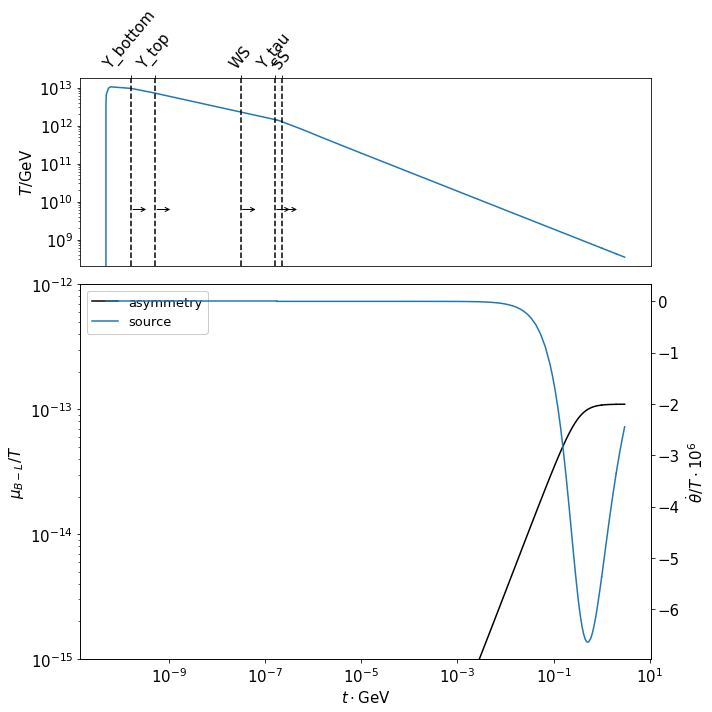

In [16]:
res = model.solve(m, collect=True)
plot_tools.plot(res, asymmetry_limits=(1e-15, 1e-12), source_scale=1e-9)

In [17]:
_B_minus_L_red_chem, T_final, axion_final = model.solve(m)

<ipython-input-7-a3c7de6667fc>:3: RuntimeWarning: overflow encountered in exp
  t = np.exp(log_t)


In [18]:
t_final = cosmology.switch_hubble_and_time_rad_dom(cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(T_final)))

In [19]:
compute_relic_density(axion_final, T_final, t_final, f, mR, M)

6.641288349722486e-08

In [20]:
t_osc = cosmology.switch_hubble_and_time_rad_dom(cosmology.calc_hubble_parameter(cosmology.calc_entropy_density(T_osc)))

In [21]:
"%e %e" % (t_final, t_osc)

'3.000000e+00 2.236517e+09'

Text(0, 0.5, 'V_eff / GeV^4')

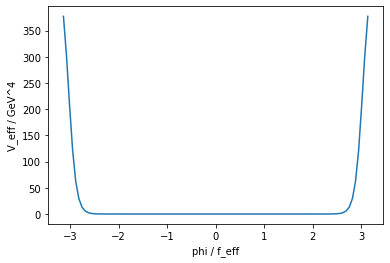

In [22]:
theta_range = np.linspace(-np.pi, np.pi, 100)
phi_over_f_range = f_eff * theta_range / f # not a linear map
plt.plot(theta_range, calc_V_eff_over_f_sq(phi_over_f_range, eps, M))
plt.xlabel("phi / f_eff")
plt.ylabel("V_eff / GeV^4")

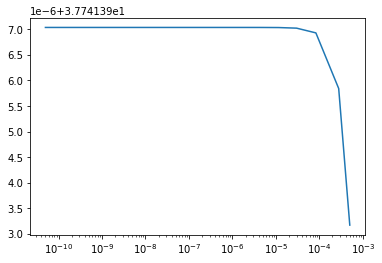

In [23]:
T_fn_rad_dom, H_fn_rad_dom = make_rad_dom_H_fn(tf, T_fn(tf))
sol_sbg = evolve(t0, tf, (theta_to_phi_over_f(1.0, eps), 0), (eps, M, H_fn))
plt.semilogx(sol_sbg.t, sol_sbg.y[0])

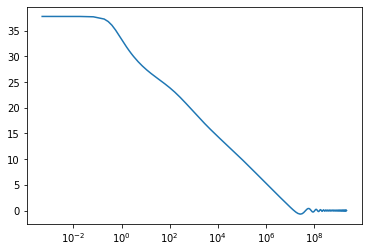

In [24]:
sol_relic = evolve(tf, t_osc, sol_sbg.y[:, -1], (eps, M, H_fn_rad_dom))
plt.semilogx(sol_relic.t, sol_relic.y[0])

Text(0, 0.5, 'Y')

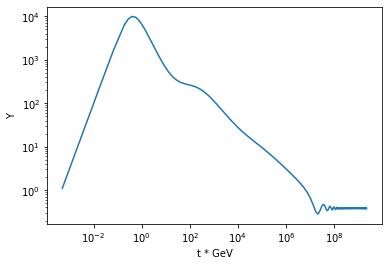

In [25]:
Y = calc_abundance(*sol_relic.y, T_fn_rad_dom(sol_relic.t), eps, f, M)
plt.loglog(sol_relic.t, Y)
plt.xlabel("t * GeV")
plt.ylabel("Y")

In [26]:
compute_relic_density(sol_sbg.y[:, -1], T_fn(sol_sbg.t[-1]), sol_sbg.t[-1], f, mR, M)

6.670749613495643e-08

In [38]:
N = 10
m_phi_range = np.geomspace(1e-5, 1e5, N) * 1e-9 # [GeV]
mR_range = np.linspace(0, 15, N)[1:]
f_eff = 1e13 # GeV

In [43]:
def compute_observables(m_phi, mR, f_eff, Gamma_phi, H_inf):
    try:
        eps = calc_eps(mR)
        f = calc_f(f_eff, eps)
        M = calc_mass_scale(m_phi, eps)
        m = model.AxionBaryogenesisModel(
            source_vector=transport_equation.source_vector_weak_sphaleron, 
            get_axion_source=get_axion_source_clockwork,
            axion_rhs=rhs_log_t,
            calc_axion_mass=calc_mass,
            axion_parameter=(eps, M),
            axion_initial=(theta_to_phi_over_f(1.0, eps), 0),
            Gamma_phi=Gamma_phi,
            H_inf=H_inf,
        )
        red_chem_pot_B_minus_L, T_final, axion_final = model.solve(m)
        t_final = cosmology.switch_hubble_and_time_rad_dom(cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(T_final)))
        eta_B = cosmology.calc_eta_B_final(red_chem_pot_B_minus_L, T_final)
        Omega_a_h_sq = compute_relic_density(axion_final, T_final, t_final, f, mR, M)
        return eta_B, Omega_a_h_sq
    except Exception:
        return np.nan, np.nan

In [96]:
H_inf = 1e8
Gamma_phi = H_inf
%time obs = [[compute_observables(m_phi, mR, f_eff, Gamma_phi, H_inf) for m_phi in m_phi_range] for mR in mR_range]

<ipython-input-7-a3c7de6667fc>:3: RuntimeWarning: overflow encountered in exp
  t = np.exp(log_t)
/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:35: RuntimeWarning: overflow encountered in exp
  _, rho_tot = np.exp(sol.sol(np.log(t)))
<ipython-input-7-a3c7de6667fc>:5: RuntimeWarning: overflow encountered in double_scalars
  return phi_dot_over_f * t, phi_dot_dot_over_f * t
<ipython-input-5-92ac107286bd>:7: RuntimeWarning: overflow encountered in double_scalars
  return 4 * M**2 * calc_du_dphi_times_f(phi_over_f, eps) / (u**3 * (1 + 1 / u**2)**2)


CPU times: user 1min 15s, sys: 3.53 ms, total: 1min 15s
Wall time: 1min 15s


In [98]:
obs = np.array(obs)

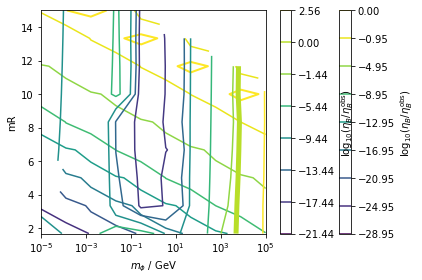

In [107]:
A = np.log10(obs[:, :, 0] / constants.eta_B_observed)
level = np.sort(np.concatenate([[0], np.arange(np.nanmin(A), np.nanmax(A), 4)]))
C1 = plt.contour(m_phi_range * 1e9, mR_range, A, levels=level, cmap="viridis")
C1.collections[np.where(C1.levels == 0)[0][0]].set_color("black")
C1.collections[np.where(C1.levels == 0)[0][0]].set_linewidths(2)
plt.colorbar().set_label(r"$\log_{10} ( \eta_B / \eta_B^{\mathrm{obs}})$")

B = np.log10(obs[:, :, 1] / constants.Omega_DM_h_sq)
level = np.sort(np.concatenate([[0], np.arange(np.nanmin(B), np.nanmax(B), 4)]))
C2 = plt.contour(m_phi_range * 1e9, mR_range, B, levels=level) # , cmap="plasma")
C2.collections[np.where(C2.levels == 0)[0][0]].set_linewidths(5)
C2.collections[np.where(C2.levels == 0)[0][0]].set_color("black")
plt.colorbar().set_label(r"$\log_{10} ( \eta_B / \eta_B^{\mathrm{obs}})$")

plt.xlabel("$m_\phi$ / GeV")
plt.ylabel("mR")
plt.xscale("log")
plt.tight_layout()

In [61]:
obs[:,:,1]

array([[5.73678357e-13, 5.22264385e-10, 2.10805702e-08, 3.22172156e-07,
        1.74787550e-12, 1.83114124e-17, 2.04809122e-09, 2.98716401e-03,
        1.54931083e+00, 1.44186509e+02],
       [7.68594867e-14, 1.41216036e-11, 5.10281468e-08, 1.46477859e-14,
        1.15518753e-20, 4.23820464e-18, 6.38049067e-10, 8.88922533e-04,
        1.62274539e+00, 1.40266487e+02],
       [           nan, 1.10640276e-09, 1.09493997e-07, 7.04769509e-15,
        1.77680541e-20, 2.22147804e-18, 2.94558612e-10, 4.23389463e-04,
        8.20422246e-01, 1.06203411e+02],
       [5.37542492e-12, 6.48907540e-10, 6.42867957e-08, 4.13020391e-15,
        4.40336258e-23, 3.17769020e-19, 1.72177120e-10, 2.48590076e-04,
        4.84108979e-01, 9.51614913e+01],
       [3.52874877e-12, 4.25861204e-10, 4.21010722e-08, 2.70955046e-15,
        4.34349417e-23, 7.51766257e-18, 1.31724225e-10, 1.63198346e-04,
        3.16592464e-01, 7.89500985e+01],
       [2.49057806e-12, 3.00675293e-10, 2.97107130e-08, 2.50235495e-06,
   